# 03 Networks exploration

This notebook shows how networks were built and visualised based on the output from the topic model.

In [1]:
library(tidyverse)
library(tidytext)
library(topicmodels)

# old version of networks are made with igraph+ggraph
library(igraph)
library(sna)
library(ggraph)

# recent updates & community detection are made with tidygraph
library(tidygraph)

# libs for some grid/facet_wrap manipulations
library(grid)
library(gtable)
library(ggplotify)

# basic colouring and layout options
library(wesanderson)
library(patchwork)
theme_set(theme_minimal())

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Dołączanie pakietu: ‘igraph’


Następujące obiekty zostały zakryte z ‘package:dplyr’:

    as_data_frame, groups, union


Następujące obiekty zostały zakryte z ‘package:purrr’:

    compose, simplify


Następujący obiekt został zakryty z ‘package:tidyr’:

    crossing


Następujący obiekt został zakryty z ‘package:tibble’:

    as_data_frame


Następujące obiekty zostały zakryte z ‘package:stats’:

    decompose, spectrum


Następujący obiekt został zakryty z ‘package:base’:

    union


Ładowanie wymaganego pakietu: statnet.common


Dołączanie pakietu: ‘statnet.common’


Następujące obiekty zostały zakryte z

In [2]:
# load model output
load("../data/lda75_output.Rda")

# load code for edges calculation
source("03_fn_calculate_edges.R")

# function to extract topic lables:
get_topic_labels = function(x, n_labels = 10) {
  
  #takes beta-matrix as an input
  top_terms = x %>%
    group_by(topic) %>%
    top_n(20, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)
  
  topic_labels = top_terms %>%
    group_by(topic) %>%
    top_n(n_labels, beta) %>%
    summarise(label=paste(term, collapse=" ")) %>%
    mutate(label = paste(topic, label, sep="_"))
  
  return(topic_labels)
}

# prepare gamma data
gamma <- gamma %>% 
    # select ONLY RNC connections & topics
    filter(corpus == "N") %>% 
    # add index for create_edges function
    mutate(index = paste0(corpus, "_", id)) %>% 
    # fix typo
    rename(author = first_line)

glimpse(gamma)

Rows: 969,525
Columns: 8
$ corpus  <chr> "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N", "N…
$ id      <chr> "1-1", "1-2", "1-3", "10-1", "10-2", "100-1", "100-2", "100-3"…
$ year    <chr> "1785", "1785", "1785", "1803", "1803", "1810", "1810", "1810"…
$ author  <chr> "ССБобров", "ССБобров", "ССБобров", "ССБобров", "ССБобров", "А…
$ formula <chr> "iamb_4", "iamb_4", "iamb_4", "iamb_4", "iamb_4", "iamb_6", "i…
$ topic   <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ gamma   <dbl> 0.019108280, 0.006211180, 0.006451613, 0.006211180, 0.00763358…
$ index   <chr> "N_1-1", "N_1-2", "N_1-3", "N_10-1", "N_10-2", "N_100-1", "N_1…


Extract topic labels

In [3]:
topic_labels <- get_topic_labels(beta, n_labels = 5)
head(topic_labels)

topic label                                 
1 1     1_старик девица красный молодой старый
2 2     2_брат два жена муж другой            
3 3     3_искать исчезать везде дух след      
4 4     4_дева прекрасный краса чистый молодой
5 5     5_бог давать сила боже господь        
6 6     6_слава великий герой отечество россия

Create edges: detect highly probable topics appeared in the same poems

In [4]:
edges_raw <- compute_edges(gamma,
                           gamma_thresh = 0.05,
                           time_slice = 5)

head(edges_raw)

corpus id      year author     formula                   topic gamma     
1 N      10256   1814 АННахимов  iamb_free                 1     0.06569343
2 N      10296-1 1848 НАНекрасов anapaest_регулярная:3+2#3 1     0.13548387
3 N      10296-1 1848 НАНекрасов anapaest_регулярная:3+2#3 1     0.13548387
4 N      10296-1 1848 НАНекрасов anapaest_регулярная:3+2#3 1     0.13548387
5 N      10296-1 1848 НАНекрасов anapaest_регулярная:3+2#3 1     0.13548387
6 N      10302   1850 НАНекрасов iamb_6                    1     0.05660377
  index     from to slice edge_id source                                
1 N_10256   1    46 1810  1 46    1_старик девица красный молодой старый
2 N_10296-1 1    15 1845  1 15    1_старик девица красный молодой старый
3 N_10296-1 1    57 1845  1 57    1_старик девица красный молодой старый
4 N_10296-1 1    58 1845  1 58    1_старик девица красный молодой старый
5 N_10296-1 1    59 1845  1 59    1_старик девица красный молодой старый
6 N_10302   1     3 1850  1 3     1_старик девица красный молодой старый
  target                                          
1 46_стих писать читать перо поэт                 
2 15_пить вино чаша пир гость                     
3 57_другой хотеть иной становиться говорить      
4 58_день ночь тень час утро                      
5 59_сказать становиться хорошо говорить приходить
6 3_искать исчезать везде дух след

Create links for network

In [5]:
# select top meters
meter_counts <- gamma %>% 
  mutate(year_span = floor(as.numeric(year)/5)*5) %>% 
  rename("meter" = "formula") %>% 
  filter(!str_detect(meter, "other")) %>% 
  group_by(year_span, meter) %>% 
  count(sort = T) %>% 
  ungroup() %>% 
  filter(n > 10 & year_span != 1850)

head(meter_counts)

year_span meter     n    
1 1825      iamb_4    54975
2 1830      iamb_4    37050
3 1820      iamb_4    36450
4 1815      iamb_free 24525
5 1840      trochee_4 22125
6 1795      iamb_4    21150

In [6]:
top_meters <- meter_counts %>% 
  group_by(meter) %>%
  summarise(total = sum(n)) %>% 
  arrange(desc(total))

head(top_meters, 15)
top_meters$meter[1:8]

meter                     total 
1  iamb_4                    287100
2  iamb_free                 158400
3  iamb_6                    111450
4  trochee_4                 109650
5  iamb_5                     56850
6  iamb_3                     25275
7  amphibrach_4               10500
8  iamb_регулярная:4+3        10425
9  amphibrach_3                6300
10 trochee_3                   5400
11 amphibrach_2                4800
12 trochee_регулярная:4+3      4800
13 iamb_регулярная:6+4         4650
14 amphibrach_регулярная:4+3   4500
15 dactyl_4                    4500

[1] "iamb_4"              "iamb_free"           "iamb_6"             
[4] "trochee_4"           "iamb_5"              "iamb_3"             
[7] "amphibrach_4"        "iamb_регулярная:4+3"

## RNC networks

In [7]:
links <- edges_raw %>% 
  mutate(meter = formula) %>%
  # filter out only 8 most interesting meters
  filter(meter %in% top_meters$meter[1:8]) %>% 
  # group and count edges
  group_by(slice, meter, corpus) %>% 
  count(slice, meter, edge_id, source, target, sort = T) %>% 
  # filter non-frequent edges
  filter(n > 2) %>% 
  ungroup() 

# quick check
head(links)

slice meter     corpus edge_id source                                    
1 1780  iamb_free N      41 57   41_лев волк зверь собака большой          
2 1840  trochee_4 N      36 51   36_знать говорить точно два очень         
3 1780  iamb_free N      57 59   57_другой хотеть иной становиться говорить
4 1780  iamb_free N      20 57   20_богатый жить дом служить бедный        
5 1810  iamb_free N      41 59   41_лев волк зверь собака большой          
6 1825  iamb_4    N      19 42   19_муза певец слава дар поэт              
  target                                           n 
1 57_другой хотеть иной становиться говорить       23
2 51_сидеть окно дверь дом стоять                  20
3 59_сказать становиться хорошо говорить приходить 19
4 57_другой хотеть иной становиться говорить       16
5 59_сказать становиться хорошо говорить приходить 16
6 42_душа мечта поэт живой восторг                 16

Create edge and node lists

In [8]:
edgelist <- links %>% 
  select(source, target, n, meter, slice, corpus) %>% 
  mutate(width = n/10) %>% 
  filter(slice != 1850)

nodelist <- tibble(source = unique(c(links$target, links$source))) %>% 
  mutate(idn = as.numeric(str_replace(source, "^([0-9].*?)_.*", "\\1"))) 

 head(edgelist)
 head(nodelist) 
 nrow(nodelist)

source                                    
1 41_лев волк зверь собака большой          
2 36_знать говорить точно два очень         
3 57_другой хотеть иной становиться говорить
4 20_богатый жить дом служить бедный        
5 41_лев волк зверь собака большой          
6 19_муза певец слава дар поэт              
  target                                           n  meter     slice corpus
1 57_другой хотеть иной становиться говорить       23 iamb_free 1780  N     
2 51_сидеть окно дверь дом стоять                  20 trochee_4 1840  N     
3 59_сказать становиться хорошо говорить приходить 19 iamb_free 1780  N     
4 57_другой хотеть иной становиться говорить       16 iamb_free 1780  N     
5 59_сказать становиться хорошо говорить приходить 16 iamb_free 1810  N     
6 42_душа мечта поэт живой восторг                 16 iamb_4    1825  N     
  width
1 2.3  
2 2.0  
3 1.9  
4 1.6  
5 1.6  
6 1.6

source                                           idn
1 57_другой хотеть иной становиться говорить       57 
2 51_сидеть окно дверь дом стоять                  51 
3 59_сказать становиться хорошо говорить приходить 59 
4 42_душа мечта поэт живой восторг                 42 
5 72_гора лес скала дикий стоять                   72 
6 62_знать хотеть ничто сказать бояться            62

[1] 75

### Create network

In [37]:
net <- graph_from_data_frame(d = edgelist, vertices = nodelist, directed = F)
net

IGRAPH abf375f UN-- 75 3748 -- 
+ attr: name (v/c), idn (v/n), n (e/n), meter (e/c), slice (e/n),
| corpus (e/c), width (e/n)
+ edges from abf375f (vertex names):
[1] 57_другой хотеть иной становиться говорить      --41_лев волк зверь собака большой                
[2] 51_сидеть окно дверь дом стоять                 --36_знать говорить точно два очень               
[3] 57_другой хотеть иной становиться говорить      --59_сказать становиться хорошо говорить приходить
[4] 57_другой хотеть иной становиться говорить      --20_богатый жить дом служить бедный              
[5] 59_сказать становиться хорошо говорить приходить--41_лев волк зверь собака большой                
+ ... omitted several edges

#### build viz

In [44]:
# function for network visualisation

# taken as input net, meter as a string & colour palette value
# corpus is "N" for RNC, "P" for periodicals

network <- function(network, meter_value, palette_v) {
  ggraph(network, layout = "stress") +
    geom_edge_fan(aes(color= meter,
                      filter = meter %in% c(meter_value), 
                      width = n, 
                      alpha = 0.4)) +
    geom_node_point() +
    geom_node_text(aes(label=idn), 
                   hjust=0.1, 
                   vjust=-0.4, 
                   size=3, 
                   color="grey50") +
    theme_void() + 
    theme(strip.text = element_text(size = 12)) +
    facet_wrap(~slice, 
               scales="free_x", 
               drop=T,
               ncol = 5) + 
    scale_edge_color_manual(values = palette_v) + 
    theme(legend.position = "None")
}

List of meter values

In [45]:
unique(edgelist$meter)

[1] "iamb_free"           "trochee_4"           "iamb_4"             
[4] "iamb_6"              "iamb_5"              "iamb_3"             
[7] "iamb_регулярная:4+3" "amphibrach_4"

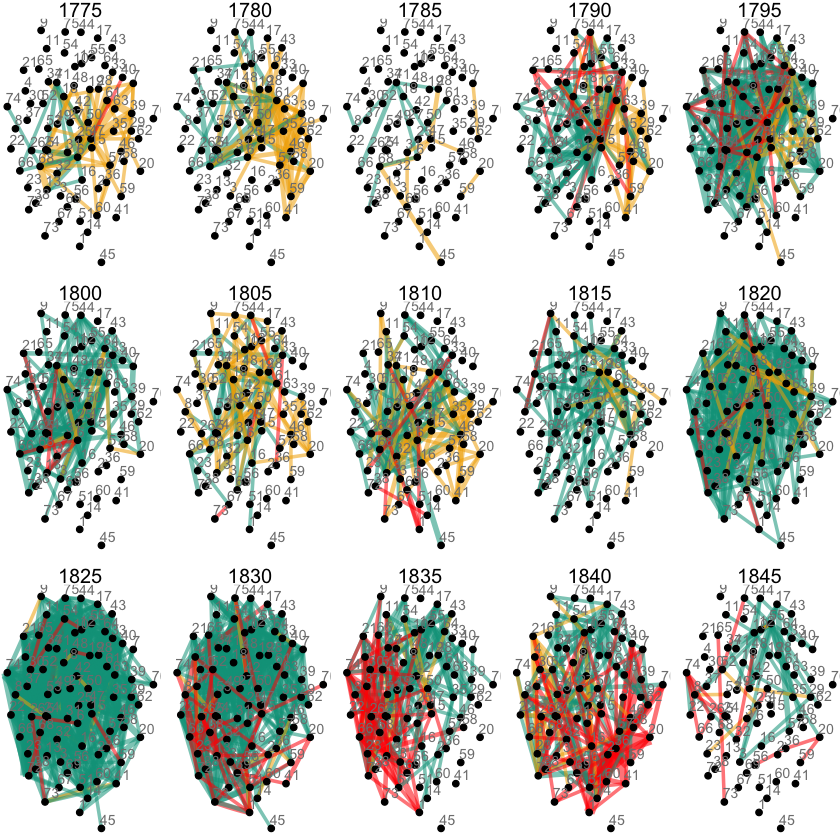

In [14]:
all_nkrja <- network(net, c("iamb_6", "iamb_4", "trochee_4"), 
                     c(wes_palette("Darjeeling1")[2], 
                       wes_palette("Darjeeling1")[3], 
                       wes_palette("Darjeeling1")[1]))
all_nkrja

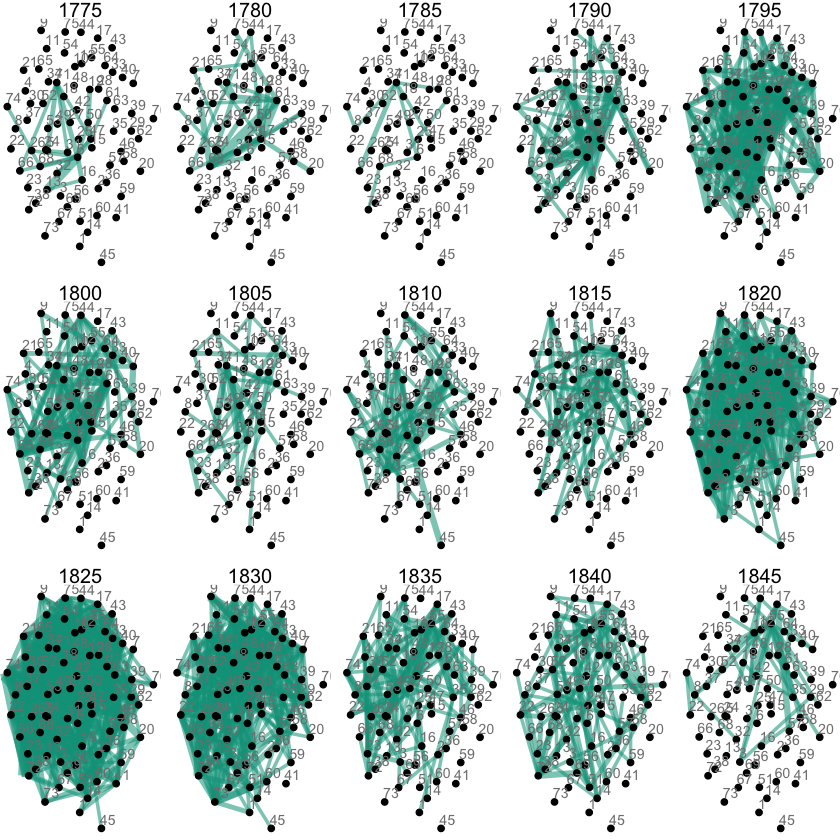

In [68]:
iamb_4 <- network(net, c("iamb_4"), wes_palette("Darjeeling1")[2]) 
iamb_4 

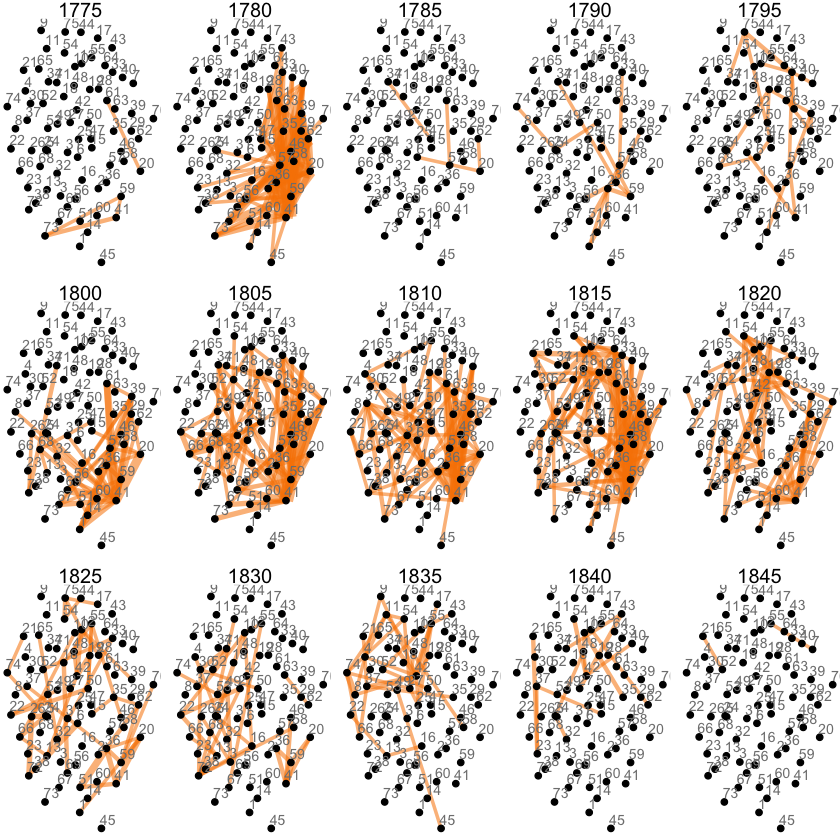

In [46]:
iamb_free <- network(net, c("iamb_free"), wes_palette("Darjeeling1")[4])
iamb_free

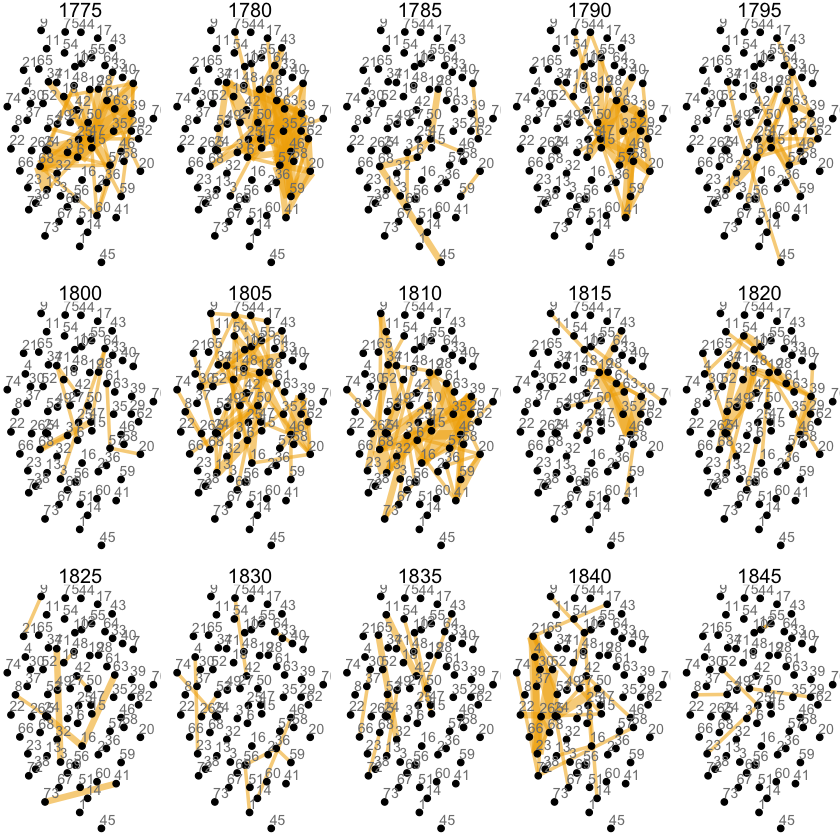

In [47]:
iamb_6 <- network(net, c("iamb_6"), wes_palette("Darjeeling1")[3])
iamb_6

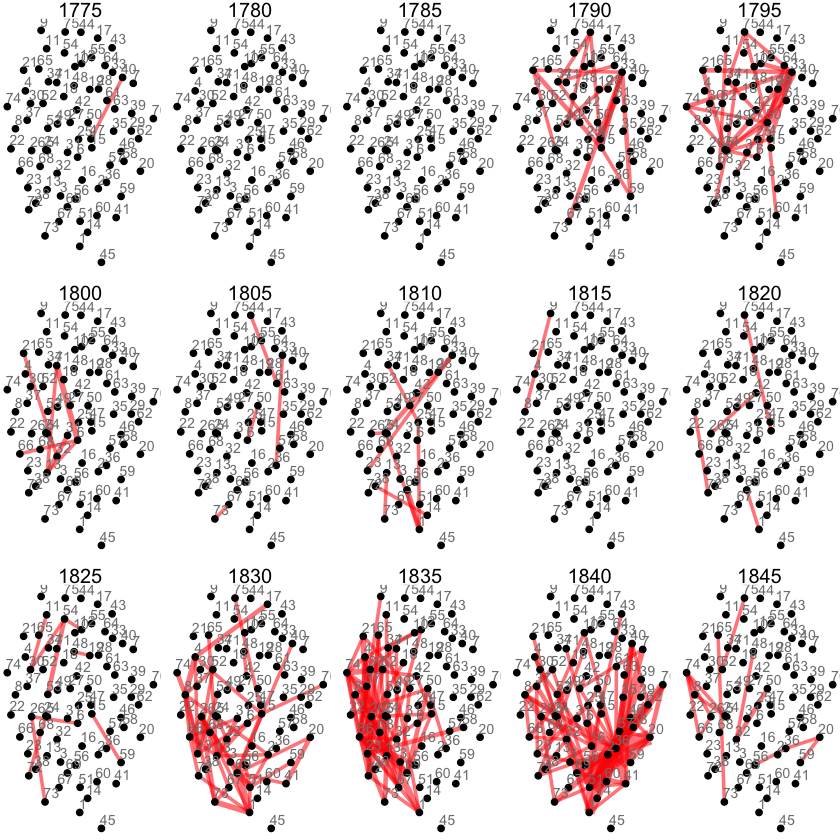

In [48]:
trochee_4 <- network(net, c("trochee_4"), wes_palette("Darjeeling1")[1])
trochee_4

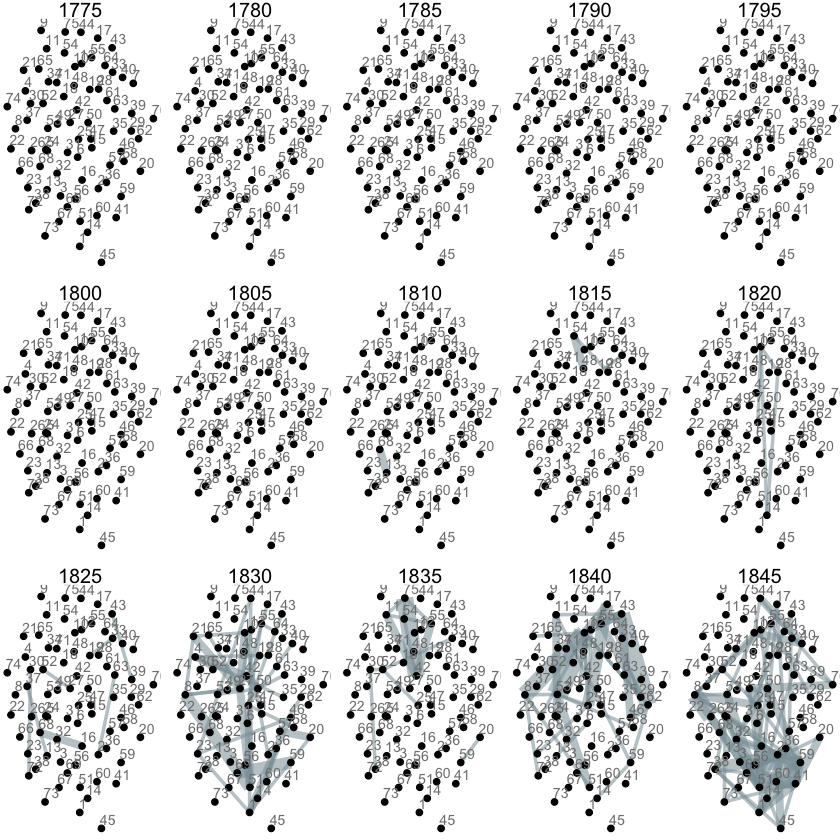

In [19]:
iamb_5 <- network(net, "iamb_5", wes_palette("Royal1")[1])
iamb_5

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <b5>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <bb>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <8f>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <8f>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <83>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <bb>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <8f>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <b0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <8f>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <b3>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <83>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <bb>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <bd>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <b0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <b5>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <b3>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <83>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <bd>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <b5>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <b3>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zas

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <8f>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d1>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <80>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsToSbcs': kropka zastąpiona <d0>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“niepowodzenie konwersji 'iamb_регулярная:4+3' w 'mbcsT

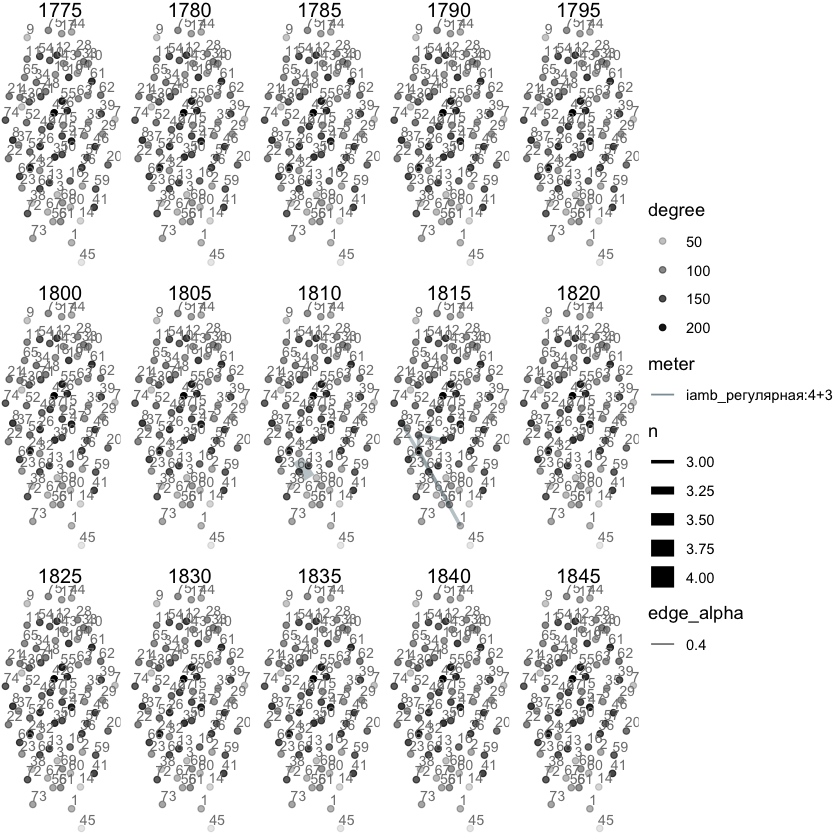

In [43]:
iamb_43 <- network(net, 
                  "iamb_регулярная:4+3",  
                   wes_palette("Royal1")[1])
iamb_43

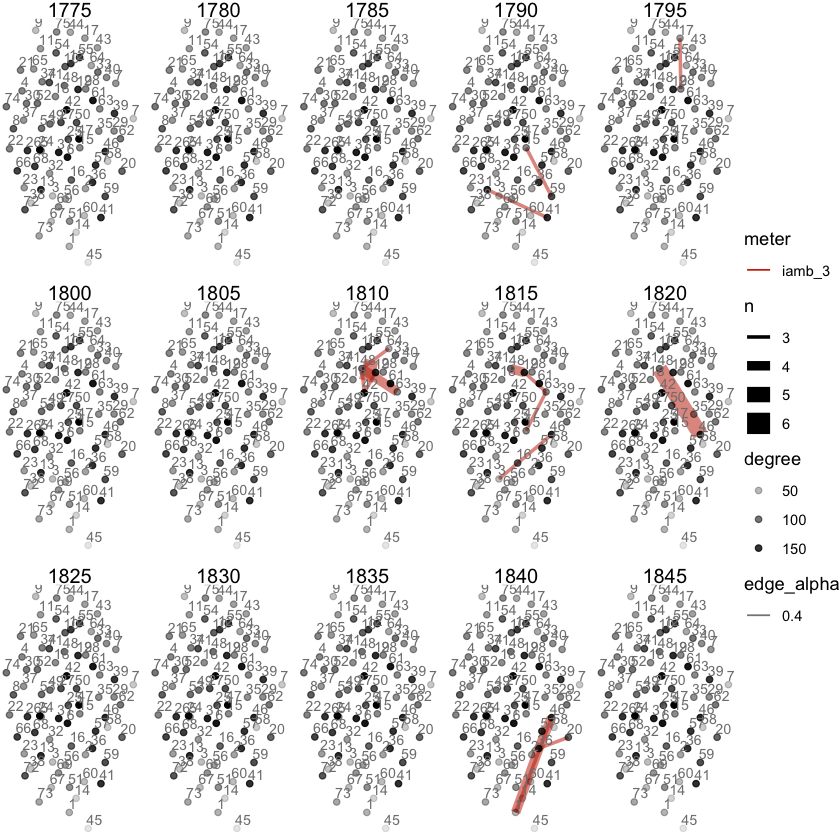

In [26]:
iamb_3 <- network(net, 
                  "iamb_3", 
                   wes_palette("Royal1")[2])
iamb_3

List and save plots

In [34]:
plotlist <- list()

plotlist$all <- all_nkrja
plotlist$iamb_4 <- iamb_4
plotlist$iamb_6 <- iamb_6
plotlist$trochee_4 <- trochee_4

In [35]:
lapply(names(plotlist), function(x)
    ggsave(filename = paste0("../plots/03_network_", x, ".png"), 
           plot = plotlist[[x]],
           height = 8, width = 10, bg = "white"))

[[1]]
[1] "../plots/03_network_all.png"

[[2]]
[1] "../plots/03_network_iamb_4.png"

[[3]]
[1] "../plots/03_network_iamb_6.png"

[[4]]
[1] "../plots/03_network_trochee_4.png"

#### Separate visualisations for networks with most edges in each meter

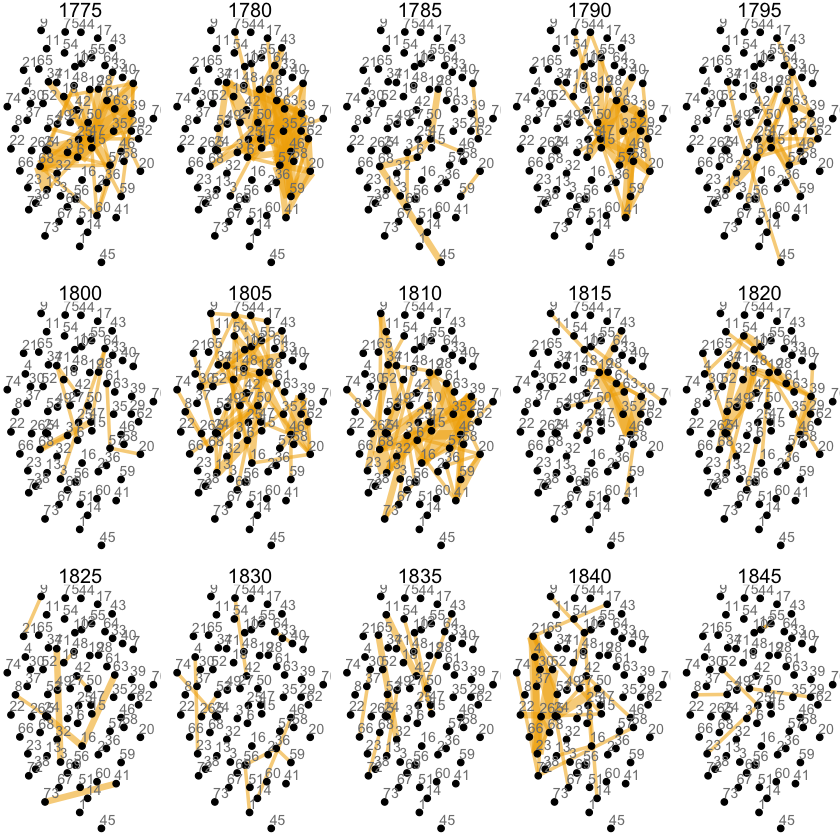

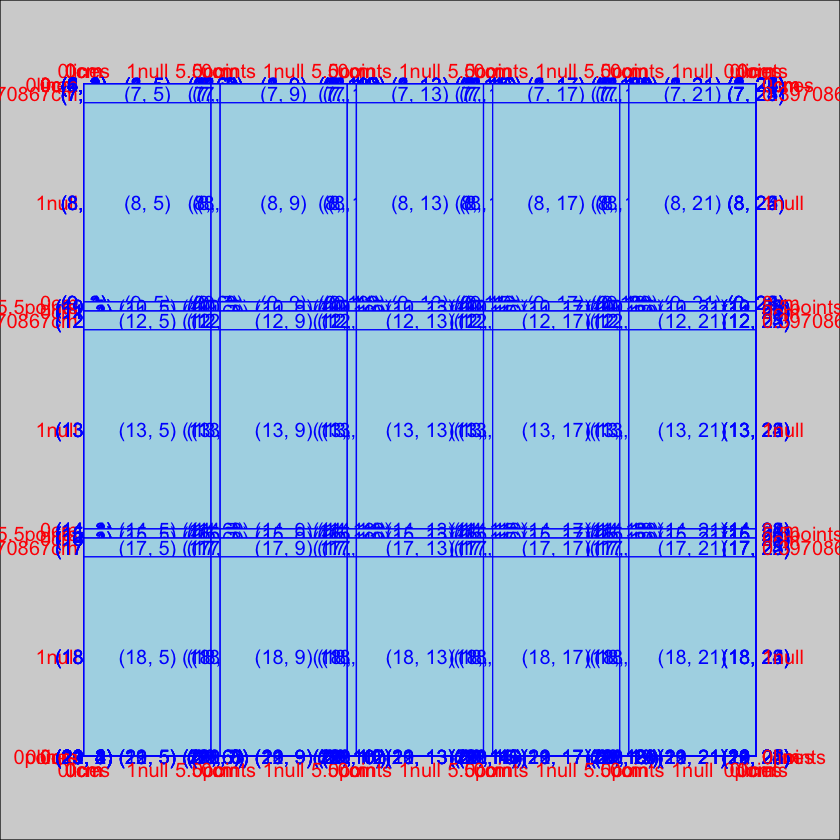

In [49]:
# plot layout
iamb_6

g1 <- ggplotGrob(iamb_6)
gtable_show_layout(g1)

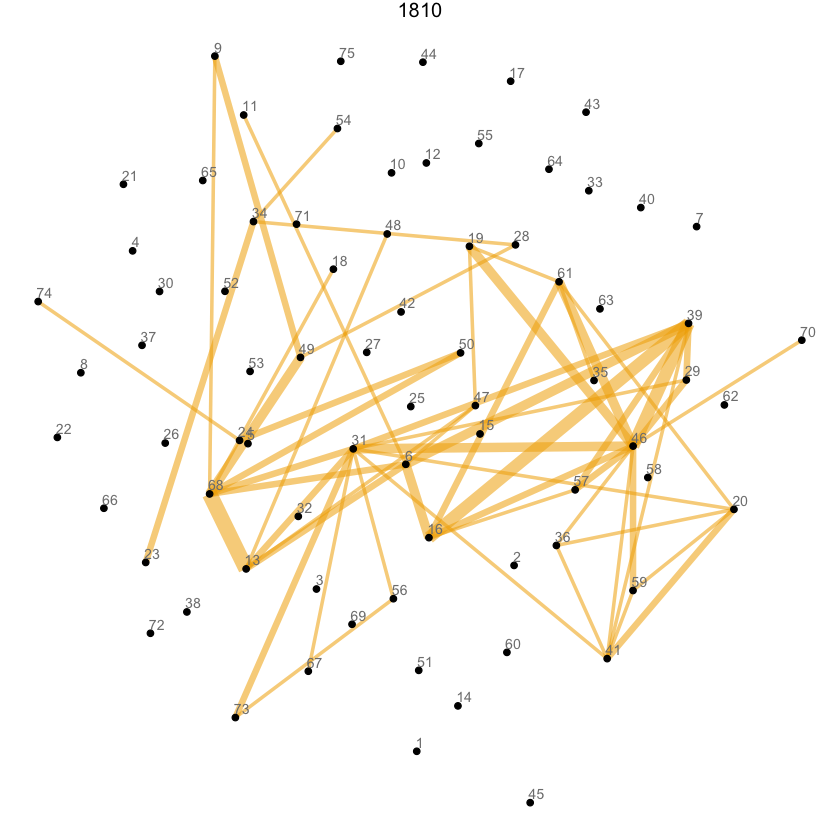

In [50]:
# select middle graph for Iamb-6 in 1810 
# can be also done by dropping other columns
#g1_am0 = g1[-c(7, 8, 17, 18),-c(5,9, 17, 21)]

iamb_6_1810 <- g1[c(12,13),13]

grid.newpage()
grid.draw(iamb_6_1810)

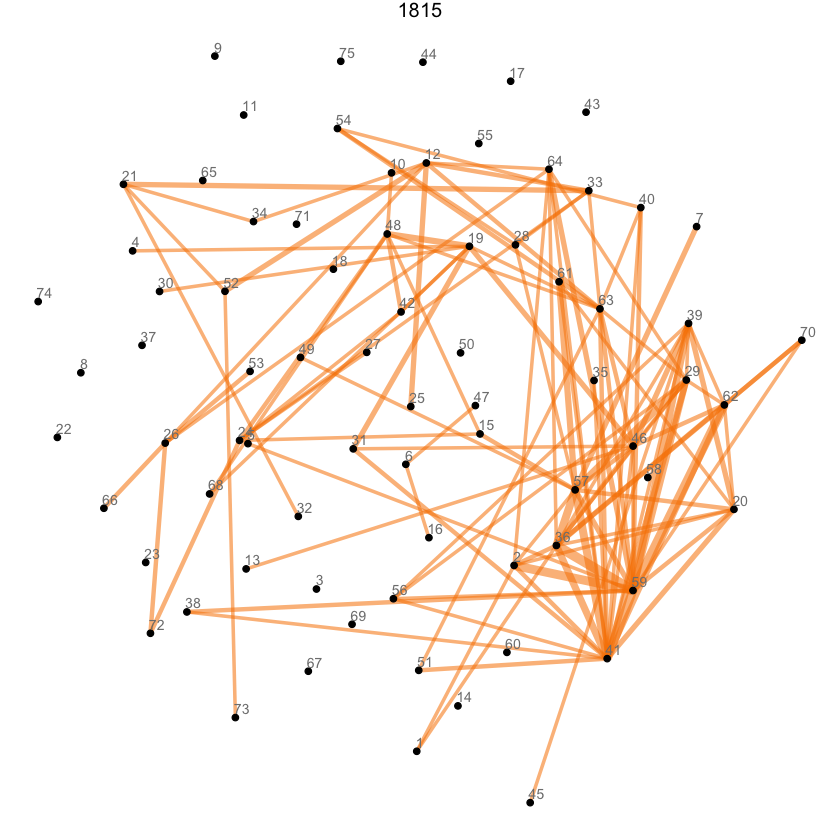

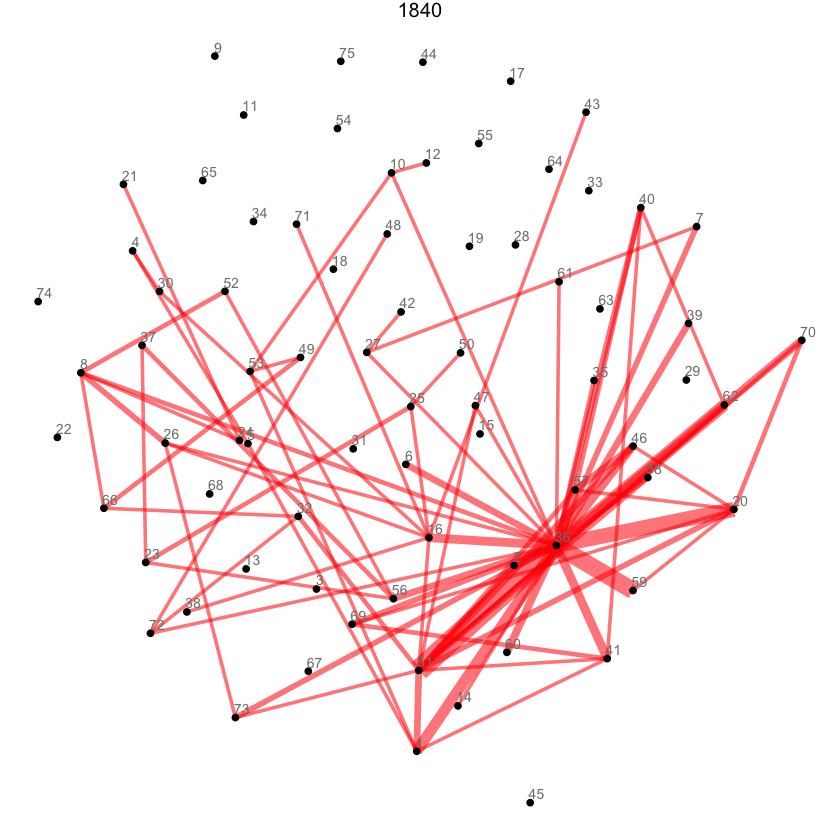

In [56]:
# Same for iamb_free 1815 & trochee-4 1840

g1 <- ggplotGrob(iamb_free)
iamb_free_1815 <- g1[c(12,13), 17]
grid.newpage()
grid.draw(iamb_free_1815)

g1 <- ggplotGrob(trochee_4)
trochee_4_1840 <- g1[c(17,18), 17]
grid.newpage()
grid.draw(trochee_4_1840)

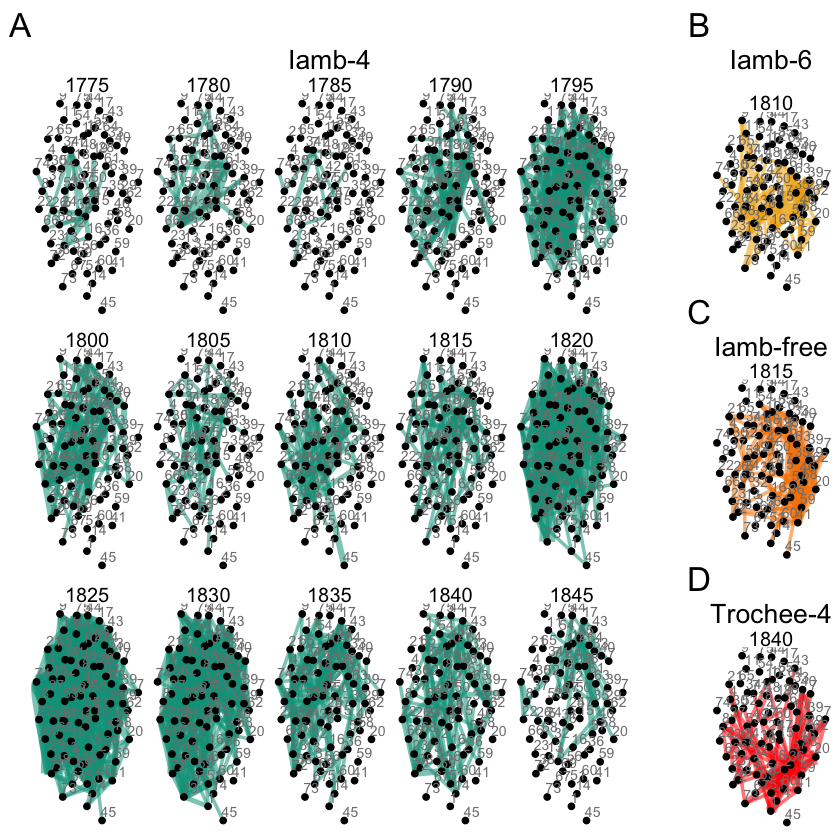

In [122]:
layout <- "
AAAAAAAAAA#BB
AAAAAAAAAA#CC
AAAAAAAAAA#DD
"

net_patch <- (iamb_4 + labs(title = "Iamb-4")) + 
    (as.ggplot(iamb_6_1810)+labs(title = "Iamb-6")) + 
    (as.ggplot(iamb_free_1815)+labs(title = "Iamb-free")) + 
    (as.ggplot(trochee_4_1840)+labs(title = "Trochee-4")) + 
  plot_layout(design = layout) & plot_annotation(tag_levels = 'A') & 
  theme(plot.title = element_text(size = 16, hjust = 0.5),
        plot.tag = element_text(size = 20)
       )

net_patch

In [123]:
ggsave(file = "../plots/03_01_selected_networks.png", plot = net_patch,
      height = 12, width = 18, dpi = 300, bg = "white")

### Analysis

In [36]:
head(nodelist)

source                                           idn
1 57_другой хотеть иной становиться говорить       57 
2 51_сидеть окно дверь дом стоять                  51 
3 59_сказать становиться хорошо говорить приходить 59 
4 42_душа мечта поэт живой восторг                 42 
5 72_гора лес скала дикий стоять                   72 
6 62_знать хотеть ничто сказать бояться            62

In [37]:
head(edgelist)

source                                    
1 41_лев волк зверь собака большой          
2 36_знать говорить точно два очень         
3 57_другой хотеть иной становиться говорить
4 20_богатый жить дом служить бедный        
5 41_лев волк зверь собака большой          
6 19_муза певец слава дар поэт              
  target                                           n  meter     slice corpus
1 57_другой хотеть иной становиться говорить       23 iamb_free 1780  N     
2 51_сидеть окно дверь дом стоять                  20 trochee_4 1840  N     
3 59_сказать становиться хорошо говорить приходить 19 iamb_free 1780  N     
4 57_другой хотеть иной становиться говорить       16 iamb_free 1780  N     
5 59_сказать становиться хорошо говорить приходить 16 iamb_free 1810  N     
6 42_душа мечта поэт живой восторг                 16 iamb_4    1825  N     
  width
1 2.3  
2 2.0  
3 1.9  
4 1.6  
5 1.6  
6 1.6

#### Number of connections for each meter in different slices

In [9]:
print("Number of connections by each meter")
edgelist %>% 
    filter(meter %in% c("iamb_4", "iamb_free", "iamb_6", "trochee_4") & corpus == "N") %>% 
    group_by(meter, slice) %>% 
    count(sort = F) %>% 
    pivot_wider(names_from = slice, values_from = n)

[1] "Number of connections by each meter"


meter     1775 1780 1785 1790 1795 1800 1805 1810 1815 1820 1825 1830 1835
1 iamb_4    19   27    9   71   185  115  39   72    81  343  610  357  137 
2 iamb_6    44   53    9   30    24    8  56   56    15   27    8    9    9 
3 iamb_free  4   89    4   15    17   50  94   91   117   70   47   31   33 
4 trochee_4  1   NA   NA   15    24    6   4    9     1    4    9   44   68 
  1840 1845
1 99   40  
2 28    6  
3 14    2  
4 84   13

### Network density
Calculate network density taking separately each time slice and each meter. The density of a graph is the ratio of the number of edges and the number of possible edges.

In [39]:
density_vector <- function(formula) {
    densities <- vector()
    e1 <- NULL
    for (i in 1:length(unique(edgelist$slice))) {
        e1 <- edgelist %>% 
            filter(meter == formula & slice == unique(edgelist$slice)[i] & corpus == "N")

            net_test <- graph_from_data_frame(d = e1, vertices = nodelist, directed = F)

            densities[i] <- edge_density(net_test, loops = F)
    }
    densities
}

In [40]:
length(unique(edgelist$slice))

[1] 15

In [41]:
density_table <- tibble(meter = c(rep("iamb_4", 15), rep("iamb_6", 15), 
                 rep("iamb_free", 15), rep("trochee_4", 15)),
      slice = rep(unique(edgelist$slice), 4),
      density = round(c(density_vector("iamb_4"),
                       density_vector("iamb_6"),
                       density_vector("iamb_free"), 
                       density_vector("trochee_4")), 3)) %>% 
    arrange(desc(-slice)) 

density_table %>% 
    # pivot for easier reading
    pivot_wider(names_from = slice, values_from = density)

meter     1775  1780  1785  1790  1795  1800  1805  1810  1815  1820  1825 
1 iamb_4    0.007 0.010 0.003 0.026 0.067 0.041 0.014 0.026 0.029 0.124 0.220
2 iamb_6    0.016 0.019 0.003 0.011 0.009 0.003 0.020 0.020 0.005 0.010 0.003
3 iamb_free 0.001 0.032 0.001 0.005 0.006 0.018 0.034 0.033 0.042 0.025 0.017
4 trochee_4 0.000 0.000 0.000 0.005 0.009 0.002 0.001 0.003 0.000 0.001 0.003
  1830  1835  1840  1845 
1 0.129 0.049 0.036 0.014
2 0.003 0.003 0.010 0.002
3 0.011 0.012 0.005 0.001
4 0.016 0.025 0.030 0.005

In [42]:
summary(density_table$density)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00300 0.01000 0.02125 0.02525 0.22000 

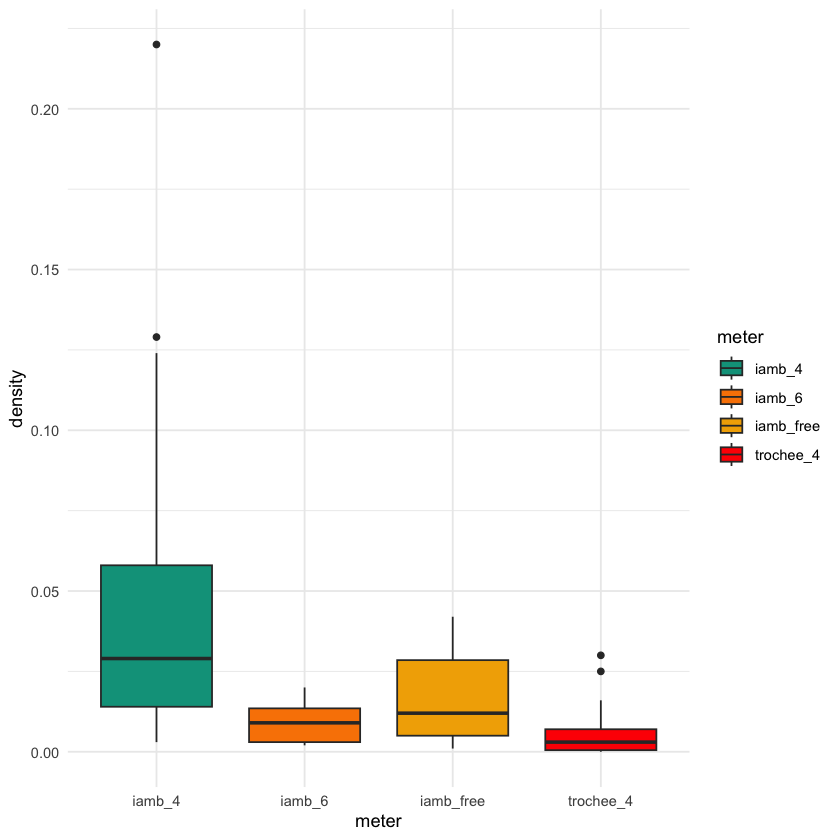

In [46]:
density_table %>% 
    ggplot(aes(x = meter, y = density, fill = meter)) + geom_boxplot() + 
    scale_fill_manual(values = c(wes_palette("Darjeeling1")[2], 
                                wes_palette("Darjeeling1")[4],
                                wes_palette("Darjeeling1")[3],
                                wes_palette("Darjeeling1")[1]))

### Degree and betweenness for each meter

**Degree** -- number of edges adjusted to a node;  
**Betweenness centrality** - number of shortest paths that go through the node;
Function below filter the data for one meter and calculate node degree and betweenness.

In [12]:
degree_betweenness <- function(formula, time_slice) {
    # create network for selected meter
    net_temp <- graph_from_data_frame(d=edgelist %>% 
                                          filter(meter == formula & slice %in% time_slice),
                                      vertices = nodelist,
                                      directed = F)

    ## betweenness
    # extract betweenness stats
    betw <- igraph::betweenness(net_temp)

    # named vector to tibble
    # str(betw)
    betw_tib <- as_tibble(as.list(betw)) %>% 
      mutate(x = "x") %>% 
      pivot_longer(!x, names_to = "source", values_to = "betw_meter") %>% 
      select(-x)

    # attach betweenness values to nodelist
    nodelist_temp <- inner_join(nodelist, betw_tib, by = "source") %>% 
        mutate(meter = formula)

    ## degree
    # extract degree values
    deg <- igraph::degree(net_temp, mode="all")

    degree_tib <- as_tibble(as.list(deg)) %>% 
      mutate(x = "x") %>% 
      pivot_longer(!x, names_to = "source", values_to = "degree_meter") %>% 
      select(-x)

    # attach degree to nodelist
    nodelist_result <- inner_join(nodelist_temp, degree_tib, by = "source")

    nodelist_result
}

In [11]:
head(edgelist)

source                                    
1 41_лев волк зверь собака большой          
2 36_знать говорить точно два очень         
3 57_другой хотеть иной становиться говорить
4 20_богатый жить дом служить бедный        
5 41_лев волк зверь собака большой          
6 19_муза певец слава дар поэт              
  target                                           n  meter     slice corpus
1 57_другой хотеть иной становиться говорить       23 iamb_free 1780  N     
2 51_сидеть окно дверь дом стоять                  20 trochee_4 1840  N     
3 59_сказать становиться хорошо говорить приходить 19 iamb_free 1780  N     
4 57_другой хотеть иной становиться говорить       16 iamb_free 1780  N     
5 59_сказать становиться хорошо говорить приходить 16 iamb_free 1810  N     
6 42_душа мечта поэт живой восторг                 16 iamb_4    1825  N     
  width
1 2.3  
2 2.0  
3 1.9  
4 1.6  
5 1.6  
6 1.6

**Iamb-4**  
time slice: from 1815 to 1835

In [42]:
print("Sort by degree")
head(degree_betweenness("iamb_4", c(1815, 1820, 1825, 1830, 1835)), 20) %>% arrange(desc(degree_meter))
print("Sort by betweenness")
head(degree_betweenness("iamb_4", c(1815, 1820, 1825, 1830, 1835)),10) %>% arrange(desc(betw_meter))

[1] "Sort by degree"


source                                           idn betw_meter  meter 
1  42_душа мечта поэт живой восторг                 42  167.6867366 iamb_4
2  55_душа жизнь страсть страдание мука             55   82.7243939 iamb_4
3  54_жизнь радость надежда день мечта              54   33.7242952 iamb_4
4  52_грудь уста сладкий нега слеза                 52   43.9603600 iamb_4
5  26_волна море берег вода брег                    26   35.5721523 iamb_4
6  19_муза певец слава дар поэт                     19   50.3747613 iamb_4
7  72_гора лес скала дикий стоять                   72   56.2311408 iamb_4
8  74_луч солнце небо заря блистать                 74    9.1893666 iamb_4
9  66_буря туча гром небо ветер                     66    8.5685389 iamb_4
10 36_знать говорить точно два очень                36   28.7184731 iamb_4
11 71_мир дух сила свет творец                      71   16.4435485 iamb_4
12 73_конь дорога поле бежать лететь                73   12.7325888 iamb_4
13 62_знать хотеть ничто сказать бояться            62    6.6253934 iamb_4
14 68_зреть глава глас внимать вещать               68    8.6787008 iamb_4
15 51_сидеть окно дверь дом стоять                  51   15.3701286 iamb_4
16 57_другой хотеть иной становиться говорить       57   10.7250237 iamb_4
17 69_царь народ русский царство князь              69    1.4161458 iamb_4
18 41_лев волк зверь собака большой                 41   10.0552149 iamb_4
19 59_сказать становиться хорошо говорить приходить 59    4.8006849 iamb_4
20 47_коль сие зреть любезный смертный              47    0.2676505 iamb_4
   degree_meter
1  119         
2   82         
3   69         
4   65         
5   65         
6   64         
7   62         
8   42         
9   39         
10  38         
11  31         
12  30         
13  27         
14  27         
15  23         
16  21         
17  15         
18  15         
19  10         
20   6

[1] "Sort by betweenness"


source                                           idn betw_meter meter 
1  42_душа мечта поэт живой восторг                 42  167.686737 iamb_4
2  72_гора лес скала дикий стоять                   72   56.231141 iamb_4
3  36_знать говорить точно два очень                36   28.718473 iamb_4
4  51_сидеть окно дверь дом стоять                  51   15.370129 iamb_4
5  57_другой хотеть иной становиться говорить       57   10.725024 iamb_4
6  41_лев волк зверь собака большой                 41   10.055215 iamb_4
7  74_луч солнце небо заря блистать                 74    9.189367 iamb_4
8  62_знать хотеть ничто сказать бояться            62    6.625393 iamb_4
9  59_сказать становиться хорошо говорить приходить 59    4.800685 iamb_4
10 69_царь народ русский царство князь              69    1.416146 iamb_4
   degree_meter
1  119         
2   62         
3   38         
4   23         
5   21         
6   15         
7   42         
8   27         
9   10         
10  15

**Iamb-6**  
time slice: 1805-1810

In [16]:
print("Sort by degree")
head(degree_betweenness("iamb_6", c(1805, 1810)),10) %>% arrange(desc(degree_meter))
print("Sort by betweenness")
head(degree_betweenness("iamb_6", c(1805, 1810)),10) %>% arrange(desc(betw_meter))

[1] "Sort by degree"


source                                           idn betw_meter meter 
1  41_лев волк зверь собака большой                 41  9.906548   iamb_6
2  57_другой хотеть иной становиться говорить       57  0.000000   iamb_6
3  59_сказать становиться хорошо говорить приходить 59  0.000000   iamb_6
4  62_знать хотеть ничто сказать бояться            62  0.000000   iamb_6
5  36_знать говорить точно два очень                36  0.000000   iamb_6
6  74_луч солнце небо заря блистать                 74  1.778571   iamb_6
7  69_царь народ русский царство князь              69  0.000000   iamb_6
8  51_сидеть окно дверь дом стоять                  51  0.000000   iamb_6
9  42_душа мечта поэт живой восторг                 42  0.000000   iamb_6
10 72_гора лес скала дикий стоять                   72  0.000000   iamb_6
   degree_meter
1  6           
2  4           
3  4           
4  3           
5  3           
6  2           
7  1           
8  0           
9  0           
10 0

[1] "Sort by betweenness"


source                                           idn betw_meter meter 
1  41_лев волк зверь собака большой                 41  9.906548   iamb_6
2  74_луч солнце небо заря блистать                 74  1.778571   iamb_6
3  57_другой хотеть иной становиться говорить       57  0.000000   iamb_6
4  51_сидеть окно дверь дом стоять                  51  0.000000   iamb_6
5  59_сказать становиться хорошо говорить приходить 59  0.000000   iamb_6
6  42_душа мечта поэт живой восторг                 42  0.000000   iamb_6
7  72_гора лес скала дикий стоять                   72  0.000000   iamb_6
8  62_знать хотеть ничто сказать бояться            62  0.000000   iamb_6
9  36_знать говорить точно два очень                36  0.000000   iamb_6
10 69_царь народ русский царство князь              69  0.000000   iamb_6
   degree_meter
1  6           
2  2           
3  4           
4  0           
5  4           
6  0           
7  0           
8  3           
9  3           
10 1

**Iamb free**  
time slice: 1800-1820

In [18]:
print("Sort by degree")
head(degree_betweenness("iamb_free", c(1800, 1805, 1810, 1815, 1820)),10) %>% arrange(desc(degree_meter))
print("Sort by betweenness")
head(degree_betweenness("iamb_free", c(1800, 1805, 1810, 1815, 1820)),10) %>% arrange(desc(betw_meter))

[1] "Sort by degree"


source                                           idn betw_meter meter    
1  41_лев волк зверь собака большой                 41  621.56728  iamb_free
2  59_сказать становиться хорошо говорить приходить 59  148.99009  iamb_free
3  36_знать говорить точно два очень                36   75.97198  iamb_free
4  57_другой хотеть иной становиться говорить       57  112.65495  iamb_free
5  62_знать хотеть ничто сказать бояться            62   28.70863  iamb_free
6  72_гора лес скала дикий стоять                   72   49.54669  iamb_free
7  42_душа мечта поэт живой восторг                 42   14.58466  iamb_free
8  69_царь народ русский царство князь              69    1.71023  iamb_free
9  51_сидеть окно дверь дом стоять                  51    0.00000  iamb_free
10 74_луч солнце небо заря блистать                 74    0.00000  iamb_free
   degree_meter
1  80          
2  47          
3  44          
4  41          
5  22          
6  11          
7   8          
8   8          
9   7          
10  1

[1] "Sort by betweenness"


source                                           idn betw_meter meter    
1  41_лев волк зверь собака большой                 41  621.56728  iamb_free
2  59_сказать становиться хорошо говорить приходить 59  148.99009  iamb_free
3  57_другой хотеть иной становиться говорить       57  112.65495  iamb_free
4  36_знать говорить точно два очень                36   75.97198  iamb_free
5  72_гора лес скала дикий стоять                   72   49.54669  iamb_free
6  62_знать хотеть ничто сказать бояться            62   28.70863  iamb_free
7  42_душа мечта поэт живой восторг                 42   14.58466  iamb_free
8  69_царь народ русский царство князь              69    1.71023  iamb_free
9  51_сидеть окно дверь дом стоять                  51    0.00000  iamb_free
10 74_луч солнце небо заря блистать                 74    0.00000  iamb_free
   degree_meter
1  80          
2  47          
3  41          
4  44          
5  11          
6  22          
7   8          
8   8          
9   7          
10  1

**Trochee-4**  
time slice: 1830 - 1840

In [19]:
print("Sort by degree")
head(degree_betweenness("trochee_4", c(1830, 1835, 1840)),10) %>% arrange(desc(degree_meter))
print("Sort by betweenness")
head(degree_betweenness("trochee_4", c(1830, 1835, 1840)),10) %>% arrange(desc(betw_meter))

[1] "Sort by degree"


source                                           idn betw_meter  meter    
1  36_знать говорить точно два очень                36  745.4580268 trochee_4
2  51_сидеть окно дверь дом стоять                  51  170.4912004 trochee_4
3  69_царь народ русский царство князь              69   96.9238009 trochee_4
4  72_гора лес скала дикий стоять                   72  104.0843064 trochee_4
5  74_луч солнце небо заря блистать                 74   27.2768863 trochee_4
6  41_лев волк зверь собака большой                 41    3.2131592 trochee_4
7  57_другой хотеть иной становиться говорить       57    1.0666667 trochee_4
8  42_душа мечта поэт живой восторг                 42   15.0643162 trochee_4
9  59_сказать становиться хорошо говорить приходить 59    0.0000000 trochee_4
10 62_знать хотеть ничто сказать бояться            62    0.3666667 trochee_4
   degree_meter
1  30          
2  20          
3  14          
4  11          
5  10          
6   7          
7   5          
8   4          
9   3          
10  3

[1] "Sort by betweenness"


source                                           idn betw_meter  meter    
1  36_знать говорить точно два очень                36  745.4580268 trochee_4
2  51_сидеть окно дверь дом стоять                  51  170.4912004 trochee_4
3  72_гора лес скала дикий стоять                   72  104.0843064 trochee_4
4  69_царь народ русский царство князь              69   96.9238009 trochee_4
5  74_луч солнце небо заря блистать                 74   27.2768863 trochee_4
6  42_душа мечта поэт живой восторг                 42   15.0643162 trochee_4
7  41_лев волк зверь собака большой                 41    3.2131592 trochee_4
8  57_другой хотеть иной становиться говорить       57    1.0666667 trochee_4
9  62_знать хотеть ничто сказать бояться            62    0.3666667 trochee_4
10 59_сказать становиться хорошо говорить приходить 59    0.0000000 trochee_4
   degree_meter
1  30          
2  20          
3  11          
4  14          
5  10          
6   4          
7   7          
8   5          
9   3          
10  3

#### The most frequent connections

In [67]:
head(links)

slice meter     corpus edge_id source                                    
1 1780  iamb_free N      41 57   41_лев волк зверь собака большой          
2 1840  trochee_4 N      36 51   36_знать говорить точно два очень         
3 1780  iamb_free N      57 59   57_другой хотеть иной становиться говорить
4 1780  iamb_free N      20 57   20_богатый жить дом служить бедный        
5 1810  iamb_free N      41 59   41_лев волк зверь собака большой          
6 1825  iamb_4    N      19 42   19_муза певец слава дар поэт              
  target                                           n 
1 57_другой хотеть иной становиться говорить       23
2 51_сидеть окно дверь дом стоять                  20
3 59_сказать становиться хорошо говорить приходить 19
4 57_другой хотеть иной становиться говорить       16
5 59_сказать становиться хорошо говорить приходить 16
6 42_душа мечта поэт живой восторг                 16

In [32]:
# function to count and displays top 5 connection pairs according to meter & time 

top_connections <- function(formula, time_slice) {
    x <- NULL
    x <- links %>% 
        filter(slice %in% time_slice) %>%
        filter(meter %in% formula) %>% 
        group_by(meter, edge_id, slice) %>% 
        summarise(
            source = source, 
            target = target,
            slice = slice,
            sum_links = sum(n)) %>%
        ungroup() %>%
        distinct() %>%
        arrange(desc(sum_links)) %>% 
        group_by(meter, slice) %>% 
        top_n(5, sum_links) %>% 
        arrange(-desc(meter)) %>% 
        arrange(-desc(slice))
    x
}

**Iamb-4**

In [41]:
top_connections("iamb_4", c(1815, 1820, 1825, 1830, 1835)) 

`summarise()` has grouped output by 'meter', 'edge_id'. You can override using
the `.groups` argument.


meter  edge_id slice source                                  
1  iamb_4 19 50   1815  19_муза певец слава дар поэт            
2  iamb_4 19 48   1815  19_муза певец слава дар поэт            
3  iamb_4 12 64   1815  12_любовь сердце страсть кровь чувство  
4  iamb_4 13 72   1815  13_меч бой враг герой поле              
5  iamb_4 19 33   1815  19_муза певец слава дар поэт            
6  iamb_4 19 39   1815  19_муза певец слава дар поэт            
7  iamb_4 19 46   1815  19_муза певец слава дар поэт            
8  iamb_4 24 26   1815  24_вода луг тень ручей роща             
9  iamb_4 13 73   1820  13_меч бой враг герой поле              
10 iamb_4 13 72   1820  13_меч бой враг герой поле              
11 iamb_4 19 42   1820  19_муза певец слава дар поэт            
12 iamb_4 13 26   1820  13_меч бой враг герой поле              
13 iamb_4 13 31   1820  13_меч бой враг герой поле              
14 iamb_4 13 65   1820  13_меч бой враг герой поле              
15 iamb_4 15 48   1820  15_пить вино чаша пир гость             
16 iamb_4 24 72   1820  24_вода луг тень ручей роща             
17 iamb_4 31 61   1820  31_враг смерть страшный ужасный кровь   
18 iamb_4 19 42   1825  19_муза певец слава дар поэт            
19 iamb_4 26 72   1825  26_волна море берег вода брег           
20 iamb_4 24 74   1825  24_вода луг тень ручей роща             
21 iamb_4 12 42   1825  12_любовь сердце страсть кровь чувство  
22 iamb_4 26 66   1825  26_волна море берег вода брег           
23 iamb_4 30 74   1825  30_небо земля мир земной небесный       
24 iamb_4 42 52   1825  42_душа мечта поэт живой восторг        
25 iamb_4 72 74   1825  72_гора лес скала дикий стоять          
26 iamb_4 12 42   1830  12_любовь сердце страсть кровь чувство  
27 iamb_4 10 54   1830  10_пора день память помнить забывать    
28 iamb_4 25 27   1830  25_взор око речь взгляд улыбка          
29 iamb_4 26 72   1830  26_волна море берег вода брег           
30 iamb_4 28 55   1830  28_счастие судьба пускай находить давать
31 iamb_4 54 55   1830  54_жизнь радость надежда день мечта     
32 iamb_4 9 10    1830  9_час ждать прийти последний спешить    
33 iamb_4 12 55   1835  12_любовь сердце страсть кровь чувство  
34 iamb_4 23 52   1835  23_белый грудь черный лицо кудри        
35 iamb_4 26 74   1835  26_волна море берег вода брег           
36 iamb_4 27 49   1835  27_сердце дума душа тоска полный        
37 iamb_4 28 55   1835  28_счастие судьба пускай находить давать
38 iamb_4 30 42   1835  30_небо земля мир земной небесный       
39 iamb_4 42 55   1835  42_душа мечта поэт живой восторг        
   target                                        sum_links
1  50_петь песня звук песнь певец                 7       
2  48_тишина мирный тихий счастливый покой        6       
3  64_милый ах забывать прощать друг              5       
4  72_гора лес скала дикий стоять                 5       
5  33_красота прелестный милый прекрасный нежный  5       
6  39_ум труд свет наука глупец                   5       
7  46_стих писать читать перо поэт                5       
8  26_волна море берег вода брег                  5       
9  73_конь дорога поле бежать лететь             12       
10 72_гора лес скала дикий стоять                11       
11 42_душа мечта поэт живой восторг              11       
12 26_волна море берег вода брег                  9       
13 31_враг смерть страшный ужасный кровь          9       
14 65_край страна родной чужой далекий            9       
15 48_тишина мирный тихий счастливый покой        9       
16 72_гора лес скала дикий стоять                 9       
17 61_правда суд закон дело зло                   9       
18 42_душа мечта поэт живой восторг              16       
19 72_гора лес скала дикий стоять                16       
20 74_луч солнце небо заря блистать              14       
21 42_душа мечта поэт живой восторг              12       
22 66_буря туча гром небо ветер                  11       
23 74_луч солнце небо заря блистать           

**Iamb-6**

In [33]:
top_connections("iamb_6", c(1805, 1810, 1815))

`summarise()` has grouped output by 'meter', 'edge_id'. You can override using
the `.groups` argument.


meter  edge_id slice source                                       
1  iamb_6 39 46   1805  39_ум труд свет наука глупец                 
2  iamb_6 46 62   1805  46_стих писать читать перо поэт              
3  iamb_6 6 13    1805  6_слава великий герой отечество россия       
4  iamb_6 16 19   1805  16_древний век храм москва глава             
5  iamb_6 19 30   1805  19_муза певец слава дар поэт                 
6  iamb_6 19 46   1805  19_муза певец слава дар поэт                 
7  iamb_6 24 50   1805  24_вода луг тень ручей роща                  
8  iamb_6 28 54   1805  28_счастие судьба пускай находить давать     
9  iamb_6 28 75   1805  28_счастие судьба пускай находить давать     
10 iamb_6 33 71   1805  33_красота прелестный милый прекрасный нежный
11 iamb_6 34 55   1805  34_слеза сердце плакать тоска печаль         
12 iamb_6 46 57   1805  46_стих писать читать перо поэт              
13 iamb_6 13 68   1810  13_меч бой враг герой поле                   
14 iamb_6 16 39   1810  16_древний век храм москва глава             
15 iamb_6 39 46   1810  39_ум труд свет наука глупец                 
16 iamb_6 19 46   1810  19_муза певец слава дар поэт                 
17 iamb_6 31 46   1810  31_враг смерть страшный ужасный кровь        
18 iamb_6 46 61   1810  46_стих писать читать перо поэт              
19 iamb_6 49 68   1810  49_гроб могила прах земля мертвый            
20 iamb_6 6 16    1810  6_слава великий герой отечество россия       
21 iamb_6 6 39    1810  6_слава великий герой отечество россия       
22 iamb_6 46 61   1815  46_стих писать читать перо поэт              
23 iamb_6 19 46   1815  19_муза певец слава дар поэт                 
24 iamb_6 39 46   1815  39_ум труд свет наука глупец                 
25 iamb_6 19 43   1815  19_муза певец слава дар поэт                 
26 iamb_6 19 61   1815  19_муза певец слава дар поэт                 
   target                                     sum_links
1  46_стих писать читать перо поэт            6        
2  62_знать хотеть ничто сказать бояться      5        
3  13_меч бой враг герой поле                 5        
4  19_муза певец слава дар поэт               4        
5  30_небо земля мир земной небесный          4        
6  46_стих писать читать перо поэт            4        
7  50_петь песня звук песнь певец             4        
8  54_жизнь радость надежда день мечта        4        
9  75_сердце душа любовь дар радость          4        
10 71_мир дух сила свет творец                4        
11 55_душа жизнь страсть страдание мука       4        
12 57_другой хотеть иной становиться говорить 4        
13 68_зреть глава глас внимать вещать         7        
14 39_ум труд свет наука глупец               6        
15 46_стих писать читать перо поэт            6        
16 46_стих писать читать перо поэт            5        
17 46_стих писать читать перо поэт            5        
18 61_правда суд закон дело зло               5        
19 68_зреть глава глас внимать вещать         5        
20 16_древний век храм москва глава           5        
21 39_ум труд свет наука глупец               5        
22 61_правда суд закон дело зло               7        
23 46_стих писать читать перо поэт            6        
24 46_стих писать читать перо поэт            6        
25 43_душа чувство мысль сердце немой         4        
26 61_правда суд закон дело зло               4

**Iamb-free**

In [37]:
top_connections("iamb_free", c(1800, 1805, 1810, 1815, 1820))

`summarise()` has grouped output by 'meter', 'edge_id'. You can override using
the `.groups` argument.


meter     edge_id slice source                                          
1  iamb_free 20 41   1800  20_богатый жить дом служить бедный              
2  iamb_free 41 57   1800  41_лев волк зверь собака большой                
3  iamb_free 41 69   1800  41_лев волк зверь собака большой                
4  iamb_free 41 61   1800  41_лев волк зверь собака большой                
5  iamb_free 57 61   1800  57_другой хотеть иной становиться говорить      
6  iamb_free 41 59   1805  41_лев волк зверь собака большой                
7  iamb_free 59 62   1805  59_сказать становиться хорошо говорить приходить
8  iamb_free 41 62   1805  41_лев волк зверь собака большой                
9  iamb_free 41 69   1805  41_лев волк зверь собака большой                
10 iamb_free 59 70   1805  59_сказать становиться хорошо говорить приходить
11 iamb_free 41 59   1810  41_лев волк зверь собака большой                
12 iamb_free 36 41   1810  36_знать говорить точно два очень               
13 iamb_free 36 59   1810  36_знать говорить точно два очень               
14 iamb_free 41 57   1810  41_лев волк зверь собака большой                
15 iamb_free 20 41   1810  20_богатый жить дом служить бедный              
16 iamb_free 41 61   1810  41_лев волк зверь собака большой                
17 iamb_free 36 59   1815  36_знать говорить точно два очень               
18 iamb_free 2 59    1815  2_брат два жена муж другой                      
19 iamb_free 41 59   1815  41_лев волк зверь собака большой                
20 iamb_free 59 62   1815  59_сказать становиться хорошо говорить приходить
21 iamb_free 36 57   1815  36_знать говорить точно два очень               
22 iamb_free 41 57   1815  41_лев волк зверь собака большой                
23 iamb_free 19 42   1820  19_муза певец слава дар поэт                    
24 iamb_free 12 54   1820  12_любовь сердце страсть кровь чувство          
25 iamb_free 13 31   1820  13_меч бой враг герой поле                      
26 iamb_free 13 16   1820  13_меч бой враг герой поле                      
27 iamb_free 29 41   1820  29_слово сказать говорить знать никто           
28 iamb_free 36 41   1820  36_знать говорить точно два очень               
29 iamb_free 41 51   1820  41_лев волк зверь собака большой                
   target                                           sum_links
1  41_лев волк зверь собака большой                  9       
2  57_другой хотеть иной становиться говорить        8       
3  69_царь народ русский царство князь               8       
4  61_правда суд закон дело зло                      7       
5  61_правда суд закон дело зло                      6       
6  59_сказать становиться хорошо говорить приходить 15       
7  62_знать хотеть ничто сказать бояться             8       
8  62_знать хотеть ничто сказать бояться             7       
9  69_царь народ русский царство князь               7       
10 70_давать первый рука другой чей                  6       
11 59_сказать становиться хорошо говорить приходить 16       
12 41_лев волк зверь собака большой                 12       
13 59_сказать становиться хорошо говорить приходить  9       
14 57_другой хотеть иной становиться говорить        8       
15 41_лев волк зверь собака большой                  7       
16 61_правда суд закон дело зло                      7       
17 59_сказать становиться хорошо говорить приходить 10       
18 59_сказать становиться хорошо говорить приходить  9       
19 59_сказать становиться хорошо говорить приходить  9       
20 62_знать хотеть ничто сказать бояться             9       
21 57_другой хотеть иной становиться говорить        8       
22 57_другой хотеть иной становиться говорить        8       
23 42_душа мечта поэт живой восторг                  7       
24 54_жизнь радость надежда день мечта               6       
25 31_враг смерть страшный ужасный кровь             6       
26 16_древний век храм москва глава                  5       
27 41_лев волк зверь собака большой              

**Trochee-4**

In [38]:
top_connections("trochee_4", c(1830, 1835, 1840))

`summarise()` has grouped output by 'meter', 'edge_id'. You can override using
the `.groups` argument.


meter     edge_id slice source                                
1  trochee_4 1 69    1830  1_старик девица красный молодой старый
2  trochee_4 51 69   1830  51_сидеть окно дверь дом стоять       
3  trochee_4 1 73    1830  1_старик девица красный молодой старый
4  trochee_4 4 8     1830  4_дева прекрасный краса чистый молодой
5  trochee_4 8 23    1830  8_звезда небо луна ночь луч           
6  trochee_4 1 26    1835  1_старик девица красный молодой старый
7  trochee_4 13 66   1835  13_меч бой враг герой поле            
8  trochee_4 13 69   1835  13_меч бой враг герой поле            
9  trochee_4 21 23   1835  21_цветок роза цвет цвести венок      
10 trochee_4 26 66   1835  26_волна море берег вода брег         
11 trochee_4 52 74   1835  52_грудь уста сладкий нега слеза      
12 trochee_4 36 51   1840  36_знать говорить точно два очень     
13 trochee_4 36 59   1840  36_знать говорить точно два очень     
14 trochee_4 20 36   1840  20_богатый жить дом служить бедный    
15 trochee_4 36 62   1840  36_знать говорить точно два очень     
16 trochee_4 1 36    1840  1_старик девица красный молодой старый
   target                                           sum_links
1  69_царь народ русский царство князь               7       
2  69_царь народ русский царство князь               6       
3  73_конь дорога поле бежать лететь                 5       
4  8_звезда небо луна ночь луч                       5       
5  23_белый грудь черный лицо кудри                  5       
6  26_волна море берег вода брег                     6       
7  66_буря туча гром небо ветер                      6       
8  69_царь народ русский царство князь               5       
9  23_белый грудь черный лицо кудри                  5       
10 66_буря туча гром небо ветер                      5       
11 74_луч солнце небо заря блистать                  5       
12 51_сидеть окно дверь дом стоять                  20       
13 59_сказать становиться хорошо говорить приходить 16       
14 36_знать говорить точно два очень                14       
15 62_знать хотеть ничто сказать бояться            11       
16 36_знать говорить точно два очень                10

### Community detection test

In [43]:
head(edgelist)

summary(edgelist %>% filter(meter == "iamb_4"))

source                                    
1 41_лев волк зверь собака большой          
2 36_знать говорить точно два очень         
3 57_другой хотеть иной становиться говорить
4 20_богатый жить дом служить бедный        
5 41_лев волк зверь собака большой          
6 19_муза певец слава дар поэт              
  target                                           n  meter     slice corpus
1 57_другой хотеть иной становиться говорить       23 iamb_free 1780  N     
2 51_сидеть окно дверь дом стоять                  20 trochee_4 1840  N     
3 59_сказать становиться хорошо говорить приходить 19 iamb_free 1780  N     
4 57_другой хотеть иной становиться говорить       16 iamb_free 1780  N     
5 59_сказать становиться хорошо говорить приходить 16 iamb_free 1810  N     
6 42_душа мечта поэт живой восторг                 16 iamb_4    1825  N     
  width
1 2.3  
2 2.0  
3 1.9  
4 1.6  
5 1.6  
6 1.6

    source             target                n             meter          
 Length:2204        Length:2204        Min.   : 3.000   Length:2204       
 Class :character   Class :character   1st Qu.: 3.000   Class :character  
 Mode  :character   Mode  :character   Median : 3.000   Mode  :character  
                                       Mean   : 3.906                     
                                       3rd Qu.: 4.000                     
                                       Max.   :16.000                     
     slice         corpus              width       
 Min.   :1775   Length:2204        Min.   :0.3000  
 1st Qu.:1815   Class :character   1st Qu.:0.3000  
 Median :1825   Mode  :character   Median :0.3000  
 Mean   :1819                      Mean   :0.3906  
 3rd Qu.:1830                      3rd Qu.:0.4000  
 Max.   :1845                      Max.   :1.6000  

In [87]:
edgelist_test <- edgelist %>% 
    #filter time slice 
    filter(slice %in% c(1815)) %>% 
    filter(meter == "iamb_4" & n > 4) %>% 
    select(-slice) %>% 
    mutate(source_target = paste0(source, "__", target)) %>% 
    group_by(source_target) %>% 
    summarise(sum_links = sum(n)) %>% 
    separate(source_target, into = c("source", "target"), sep = "__")

nodelist_test <- tibble(source = unique(c(edgelist_test$source, 
                                 edgelist_test$target)),
                       idn = as.numeric(str_replace(source, "^([0-9].*?)_.*", "\\1")))

In [88]:
# tidy graph

net_t <- tbl_graph(nodes = nodelist_test,
                  edges = edgelist_test,
                  directed = FALSE)

In [89]:
p <- net_t %>% 
    activate(nodes) %>% 
    mutate(community = as.factor(group_louvain())) %>% 
    ggraph('kk') + 
    geom_edge_link(aes(width = sum_links, alpha = 0.5)) + 
    geom_node_point(aes(colour = community), size = 5) + 
    geom_node_text(aes(label = source)) + 
    labs(title = "1815")

ggsave(file = "../plots/test_communities/i4_1815.png", plot = p, 
      bg = "white", width = 10, height = 8, dpi = 300)

In [90]:
edgelist_test <- edgelist %>% 
    #filter time slice 
    filter(slice %in% c(1820)) %>% 
    filter(meter == "iamb_4" & n > 4) %>% 
    select(-slice) %>% 
    mutate(source_target = paste0(source, "__", target)) %>% 
    group_by(source_target) %>% 
    summarise(sum_links = sum(n)) %>% 
    separate(source_target, into = c("source", "target"), sep = "__")

nodelist_test <- tibble(source = unique(c(edgelist_test$source, 
                                 edgelist_test$target)),
                       idn = as.numeric(str_replace(source, "^([0-9].*?)_.*", "\\1")))

net_t <- tbl_graph(nodes = nodelist_test,
                  edges = edgelist_test,
                  directed = FALSE)

p <- net_t %>% 
    activate(nodes) %>% 
    mutate(community = as.factor(group_louvain())) %>% 
    ggraph('kk') + 
    geom_edge_link(aes(width = sum_links, alpha = 0.5)) + 
    geom_node_point(aes(colour = community), size = 5) + 
    geom_node_text(aes(label = source)) + 
    labs(title = "1820")

ggsave(file = "../plots/test_communities/i4_1820.png", plot = p, 
      bg = "white", width = 15, height = 10, dpi = 300)

In [97]:
edgelist_test <- edgelist %>% 
    #filter time slice 
    filter(slice %in% c(1825)) %>% 
    filter(meter == "iamb_4" & n > 4) %>% 
    select(-slice) %>% 
    mutate(source_target = paste0(source, "__", target)) %>% 
    group_by(source_target) %>% 
    summarise(sum_links = sum(n)) %>% 
    separate(source_target, into = c("source", "target"), sep = "__")

nodelist_test <- tibble(source = unique(c(edgelist_test$source, 
                                 edgelist_test$target)),
                       idn = as.numeric(str_replace(source, "^([0-9].*?)_.*", "\\1")))

net_t <- tbl_graph(nodes = nodelist_test,
                  edges = edgelist_test,
                  directed = FALSE)

p <- net_t %>% 
    activate(nodes) %>% 
    mutate(community = as.factor(group_louvain())) %>% 
    ggraph('kk') + 
    geom_edge_link(aes(width = sum_links, alpha = 0.5)) + 
    geom_node_point(aes(colour = community), size = 5) + 
    geom_node_text(aes(label = source)) + 
    labs(title = "1825")

ggsave(file = "../plots/test_communities/i4_1825.png", plot = p, 
      bg = "white", width = 20, height = 15, dpi = 300)

In [92]:
edgelist_test <- edgelist %>% 
    #filter time slice 
    filter(slice %in% c(1830)) %>% 
    filter(meter == "iamb_4" & n > 4) %>% 
    select(-slice) %>% 
    mutate(source_target = paste0(source, "__", target)) %>% 
    group_by(source_target) %>% 
    summarise(sum_links = sum(n)) %>% 
    separate(source_target, into = c("source", "target"), sep = "__")

nodelist_test <- tibble(source = unique(c(edgelist_test$source, 
                                 edgelist_test$target)),
                       idn = as.numeric(str_replace(source, "^([0-9].*?)_.*", "\\1")))

net_t <- tbl_graph(nodes = nodelist_test,
                  edges = edgelist_test,
                  directed = FALSE)

p <- net_t %>% 
    activate(nodes) %>% 
    mutate(community = as.factor(group_louvain())) %>% 
    ggraph('kk') + 
    geom_edge_link(aes(width = sum_links, alpha = 0.5)) + 
    geom_node_point(aes(colour = community), size = 5) + 
    geom_node_text(aes(label = source)) + 
    labs(title = "1830")

ggsave(file = "../plots/test_communities/i4_1830.png", plot = p, 
      bg = "white", width = 15, height = 10, dpi = 300)

In [93]:
edgelist_test <- edgelist %>% 
    #filter time slice 
    filter(slice %in% c(1835)) %>% 
    filter(meter == "iamb_4" & n > 4) %>% 
    select(-slice) %>% 
    mutate(source_target = paste0(source, "__", target)) %>% 
    group_by(source_target) %>% 
    summarise(sum_links = sum(n)) %>% 
    separate(source_target, into = c("source", "target"), sep = "__")

nodelist_test <- tibble(source = unique(c(edgelist_test$source, 
                                 edgelist_test$target)),
                       idn = as.numeric(str_replace(source, "^([0-9].*?)_.*", "\\1")))

net_t <- tbl_graph(nodes = nodelist_test,
                  edges = edgelist_test,
                  directed = FALSE)

p <- net_t %>% 
    activate(nodes) %>% 
    mutate(community = as.factor(group_louvain())) %>% 
    ggraph('kk') + 
    geom_edge_link(aes(width = sum_links, alpha = 0.5)) + 
    geom_node_point(aes(colour = community), size = 5) + 
    geom_node_text(aes(label = source)) + 
    labs(title = "1835")

ggsave(file = "../plots/test_communities/i4_1835.png", plot = p, 
      bg = "white", width = 15, height = 10, dpi = 300)